# Receiver Function Deconvolution Tutorial
## *Prof. Gary L. Pavlis, Earth and Atmospheric Sciences, Indiana University*
## Getting Started
### Overview
One of the innovations that resulted from the availability of digital data for recording earthquake was the technology of direct imaging with estimates of the impulse response of the earth to incident direct P or S phases. An estimate of the impulse response to a direct P or S phase has come to be called a *receiver function*.  The term *receiver function* is somewhat archaic as the original application was strictly to estimate near receiver crustal structure by inversion of stacked receiver function estimates.   More recent work has extended the concept and the same estimates are now routinely used to image the transition zone through techniques where "receiver function" is a misleading title.  Nonetheless, I use that title here because it is standard terminology.

MsPASS has an extensive collection of standard algorithms used for receiver function deconvolution.  It also has some novel methods.  The first section of this tutorial shows how to run the more conventional methods and the second main section shows how to run an additional algorithm I developed for MsPASS.

### Generating Simulation Data
Before we can run the algorithms we need data.  For this exercise we will use simulation data.  Simulation data has the advantage for a tutorial as you know the answer and can evaluate the strengths and weaknesses of different algorithms. 

Note this section uses a set of specialized python functions contain in a module loaded as the first line of the cell below.  Students are encouraged to look through that python code to understand how the simulations are generated here.  Students may also want to tweek that code to study the problem further.  We intentionally kept these details out of this tutorial to focus on the point of the exercise rather than the details of how we did the simulation.

In [1]:
import decon_data_generators as simulator
wavelet=simulator.make_simulation_wavelet()

That function returns a MsPASS TimeSeries data object containing the source wavelet we will use in this simulation.  The next cell plots this wavelet.  

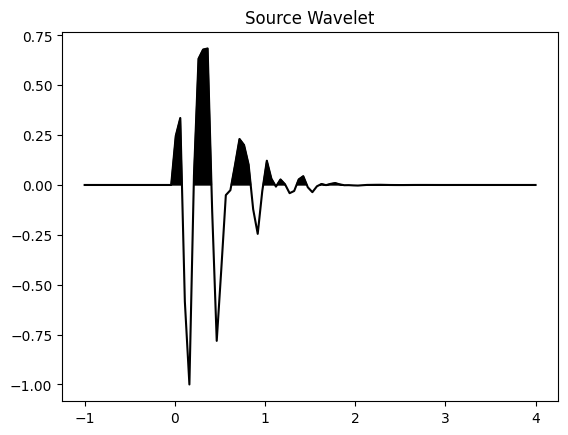

In [2]:
from mspasspy.graphics import SeismicPlotter
import matplotlib.pyplot as plt
plotter=SeismicPlotter(normalize=True,title='Source Wavelet')
plotter.change_style('wtva')
plotter.plot(wavelet)

Next we will run a small function that generates the impulse response that represents the seismogram our deconvolutions will attempt to reconstruct.

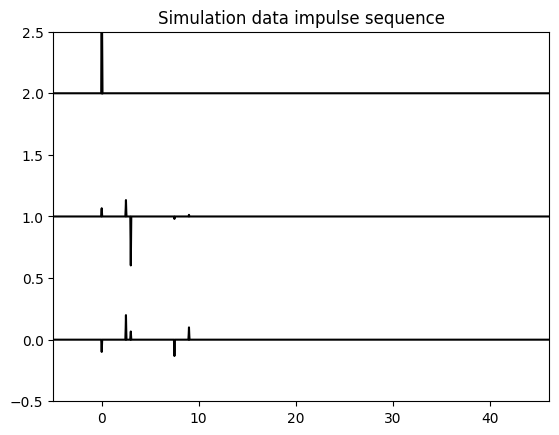

In [3]:
dimp=simulator.make_impulse_data()
plotter.title="Simulation data impulse sequence"
plotter.plot(dimp)

Noting the top signal is our simulated longitudinal component, the middle radial, and the bottom transverse.  This simulation is idealized with the longitudinal component being a single pure impulse simulating a direct P wave signal. That is never the case in reality, but an assumption of all standard methods that is important to recognize.  Our simulated radial and tranverse are not based on any physical model, but are a made up sequence created for this tutorial.

Our first, idealized data is the source wavelet convolved with the impulse sequence above.  The small function we call in the next cell performs that convolution and update our Seismogram object, d, with that data.  The result is then plotted.

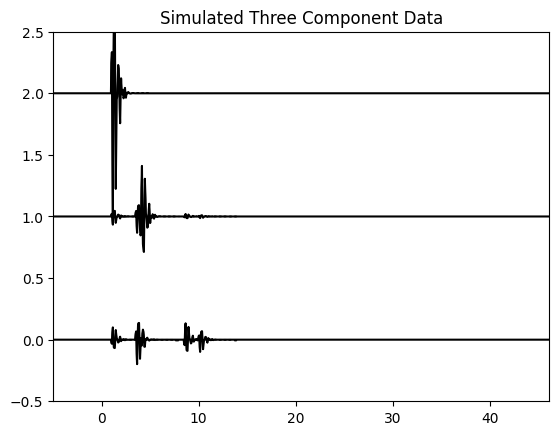

In [4]:
d=simulator.convolve_wavelet(dimp,wavelet)
plotter.title="Simulated Three Component Data"
plotter.plot(d)

The zero padding is important for the methods we will use here as all use Fourier transforms and without careful zero padding they can produce circular convolution artifacts.  Before we apply the deconvolution operators it might be helpful to zoom into the nonzero parts of this signal.

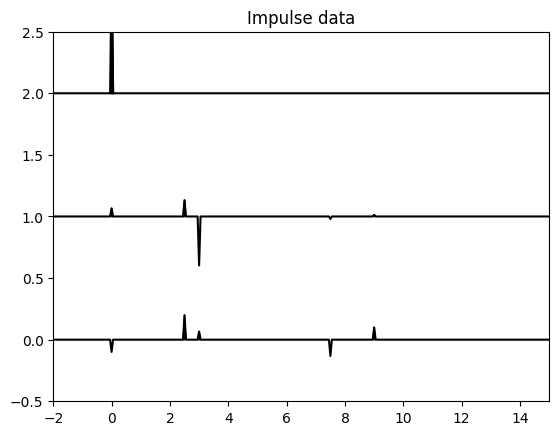

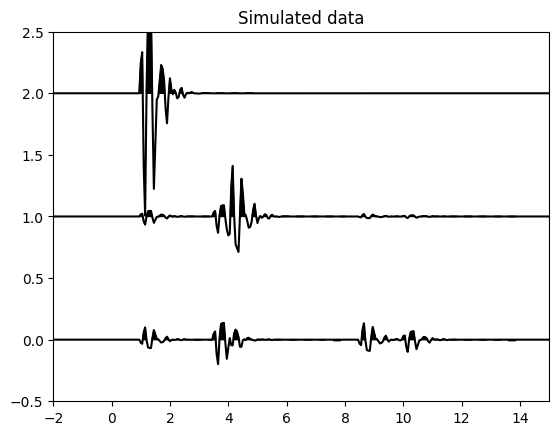

In [5]:
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.algorithms.window import WindowData
twin=TimeWindow(-2.0,15.0)
dizoom=WindowData(dimp,twin.start,twin.end)
dzoom=WindowData(d,twin.start,twin.end)
plotter.title="Impulse data"
plotter.plot(dizoom)
# We defined plt as the module for matplotlib which plotter used 
# so we can use this to force a show
plt.show()
plotter.title="Simulated data"
plotter.plot(dzoom)
plt.show()

Note a couple key points about this simulation:
1.  It illustrates the primary purpose of deconvolution.  That is, the data convolved with even a fairly compact wavelet like this only allow one to visualize larger pulses that are well separated in time.   Closely spaced impulses like those around 2 s only modulate the source wavelet to produce a different looking signal.
2.  This version of this simulation are grossly idealized as the "noise" is tiny.  (It isn't zero but defined by floating point precision which for modern 64 bit floating point formats is about 13 orders of magnitude smaller than the largest amplitude in these signals.)  For that reason the working data for this tutorial will add simulated noise.  The small function we import form the same "simulator" module we imported above.  The box below creates the working data we will use here and loads it into the symbol `dwn`.  It then plots that data at the same scale as above.

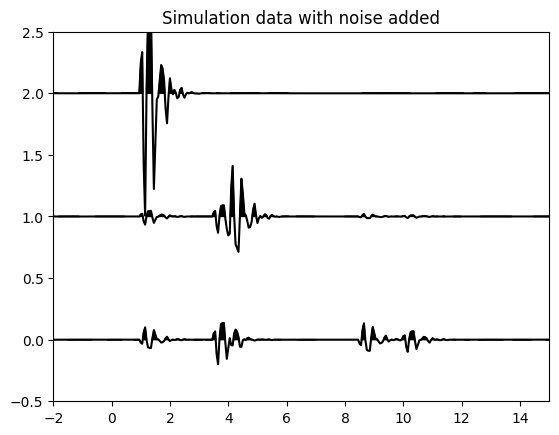

In [6]:
dwn=simulator.addnoise(d,nscale=1.0)
dzoom = WindowData(dwn,twin.start,twin.end)
plotter.title = "Simulation data with noise added"
plotter.plot(dzoom)
plt.show()

These graphics show that the signal to noise ratio of for this data is very high as the noise is barely visible.   We will see shortly, however, that naive deconvolution can still fail badly.   

## Scalar Deconvolution Methods
We have implemented a set of the most common receiver function methods that we generically classify as *scalar deconvolution method*.   By that we mean the operator is applied on pairs of scalar (single-channel) signals where one signal is assumed to be the wavelet and the other is the data to be deconvolved.  

The following methods are available in MsPASS under a common wrapper we will describe momentarily:
1.  The so called water-level method.
2.  Damped least squares implemented in the frequency domain
3.  The multitaper method as implemented by Park and Levin.
4.  A variant of the multitaper method using spectral division.
5.  The generalized iterative method (planned but not working at the time this tutorial was written).  

The "common wrapper" noted above is a set of python codes used to interact with the lower level code that does the numerics.  That code is written in C++ and the compiled code is in the module *mspass.ccore.algorithms.deconvolution*.   The wrappers provide a simplified, common interface to this set of algorithms and provide a mechanism to utilize the parallel framework of MsPASS.   Hence, the first step is to load the things we need:

### Water-level method
One of the first algorithms for decon was the so called water level method.  Here is that algorithm applied to this simulation data.

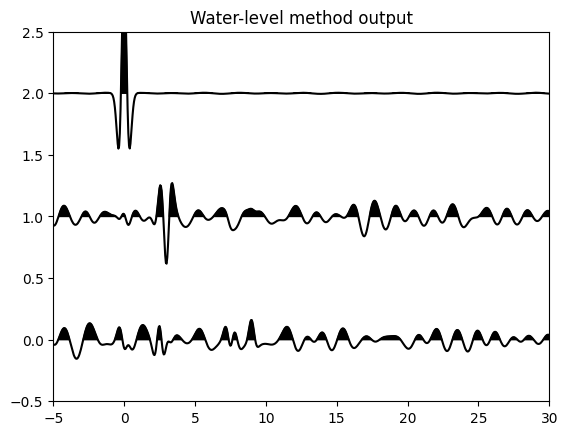

In [7]:
from mspasspy.algorithms.RFdeconProcessor import RFdecon
decondata=RFdecon(dwn,alg="WaterLevel")
plotter.title="Water-level method output"
plotter.plot(decondata)
plt.show()

### Damped least squares deconvolution
Perhaps the most common method to regularize deconvolution is damped least squares.  Although not really that common in receiver function processing it is without doubt the most commonly used deconvolution regularization because standard predictive deconvolution operators used in seismic reflection always uses this method.  In that field the damping parameter is commonly called "prewhitening" for obscure reasons best left to discussion in courses on signal processing.

To run the damped least squares estimator we can just redefine the operator and run it again like this:

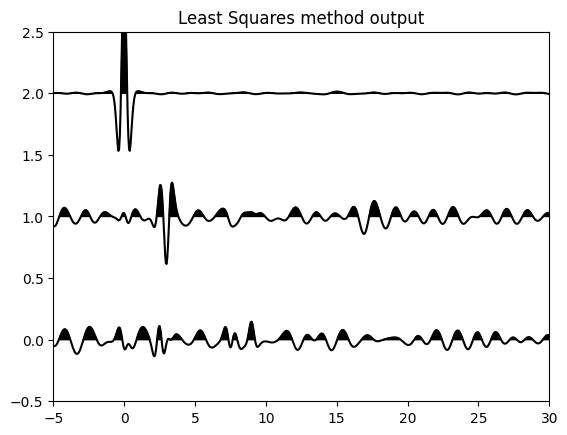

In [8]:
decondata=RFdecon(dwn,alg="LeastSquares")
plotter.title="Least Squares method output"
plotter.plot(decondata)
plt.show()

### Multitaper Deconvolution
Next let's run the two operators that use the multitaper method to estimate the inverse for the deconvolution.   These require a minor change in the run procedure.   The reason is that the methods we implemented, which are based on the original work by Park and Levin, use a frequency dependent regularization.  That regularization has the valuable feature of being a scaled version of the spectrum of an estimate of noise.  Hence, to run that algorithm the processor must be given an estimate of the noise.  The default way to handle that with this processor is to define a noise window prior to the P wave arrival and estimate the noise spectrum in that time window.  


Until this point I hid a nontrivial detail about the RFdecon function we used.   The parameters for all the deconvolution operators defined for RFdecon are loaded from a required "parameter file" that has the default name "RFDeconProcessor.pf".   RFdecon is actually only a python wrapper function to standardize the application of algorithms defined in a C++ class called the RFDeconProcessor.   The RFdecon function has a "pf" argument that can be used to change the default parameters by specifying an alternate file.  The above runs all read content of the file RFDeconProcessor.pf in the current directory.   (You can view that file in jupyter lab by just double clicking the file on the file browser window to the left or just load that file into your favorite text editor.)   

For this test the parameters we will apply for the multitaper methods will extract a noise estimate from 45 s before the P time (-45 s in the plot) to 5 s before P (-5 s in the plot) and use the spectrum of that noise to produce a frequency dependent regularization of the deconvolution operator.  The operator will also define the so called time-bandwidth product to 2.5 and use 4 tapers, which are the parameters found in Park and Levin's original paper.   The output is shaped to the same Ricker wavelet used above.

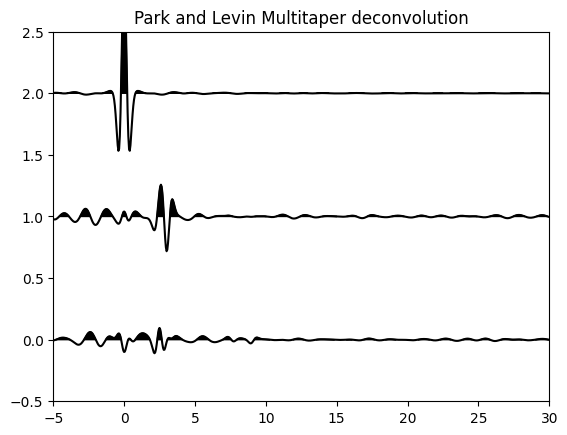

In [9]:
decondata=RFdecon(dwn,alg="MultiTaperXcor")
plotter.title="Park and Levin Multitaper deconvolution"
plotter.plot(decondata)
plt.show()

In MsPASS we also have implemented a variation on Park and Levin's algorithm that is essentially a generalization of the water level method.   The basic concept is that the water level scales with the noise spectrum.  That is, at a frequency *f* the water level is defined by *f* * *damp* where *damp* is a variation of a damping parameter.   A peculiarity of this algorithm is that *damp* should normally be greater than one to suppress noise.   When *damp<1* it is guaranteed that noise will be amplified in the deconvolved data relative to the input.  Here is the output of that algorithm:

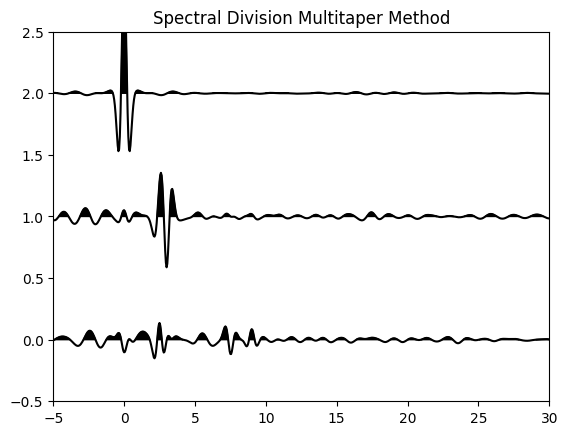

In [10]:
decondata=RFdecon(dwn,alg="MultiTaperSpecDiv")
plotter.title="Spectral Division Multitaper Method"
plotter.plot(decondata)
plt.show()

### Comparisons of Operator Performance
All of these methods amplify noise.  All of these methods have tunable parameters that can improve that behavior to some extent.   Students/readers may want to experiment with the parameters defined in the "RFdeconProcessor.pf" file to see how these operators can be tuned.   Readers who are familiar with inverse theory should recognize that that process is very much like tuning regularization for earth-model inversions.   Things like the "damping" factor in the least-squares method are exactly like damping applied in conventional, travel-time tomography inversions.  There is more to this issue, however, than is normally appreciated.  The rest of this subsection addresses what I claim is not "normally appreciated".   

A key reason the water-level and least squares method performed so badly on data with noise is this test violated an implicit assumption in both method.  That is, the form of damping we used, in particular, is often developed as an optimal deconvolution operator for white noise (*white* in this context means there is no frequency dependence).   Real data recorded on modern instrumentation nearly always violates that assumption and are, in fact, more like our simulation.  To see that, this small script computes and plots the spectrum of the time windows we used around the vertical component signal and the noise section.

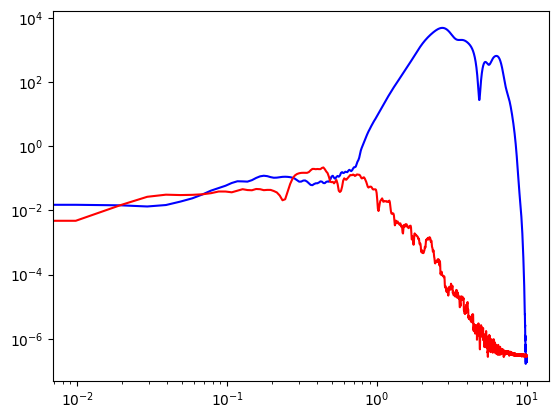

In [11]:
from mspasspy.ccore.algorithms.deconvolution import MTPowerSpectrumEngine
from mspasspy.algorithms.basic import ExtractComponent
import numpy as np
sigwindow=TimeWindow(-5.0,30.0)
nwindow=TimeWindow(-40.0,-5.0)
z=ExtractComponent(dwn,2)
sig=WindowData(z,sigwindow.start,sigwindow.end)
noise=WindowData(z,nwindow.start,nwindow.end)
engine=MTPowerSpectrumEngine(sig.npts,4.0,6,2048,sig.dt)
sigspec=engine.apply(sig)
nspec=engine.apply(noise)
plt.loglog(sigspec.frequencies(),
             sigspec.spectrum,
             'b-',
             nspec.frequencies(),
             nspec.spectrum,
             'r-',
            )
plt.show()

where the red curve is the noise spectrum and the blue curve is the signal spectrum.   The relative spectra have the same characteristic of real broadband data wherein the noise is "colored" at low frequencies.   The frequency scale in this simulation is off by about an order of magnitude, however, as earth noise in receiver function processing is dominated by microseism noise that peaks around 7 and 15 s. Furthermore, this simulation does not mimic the drop in noise level in the traditional long-peiod band.  Nonetheless this simulation demonstrates an important failing of both the water-level and least square methods;  they can fail badly even on high signal to noise ratio data in the presence of colored noise.   A typical solution used to address this problem is to increase the regularization parameters to reduce noise amplification in the output.   We leave that and some others as part of exercises for the student below.  

If you want to experiment with these algorithms you will need to launch your favorite editor.  Open the file found in this directory called RFdeconProcessor.pf. Note the file has groups of parameters like this one:
```
WaterLevel &Arr{
water_level 0.1
operator_nfft 1024
shaping_wavelet_dt 0.05
# these are appropriate for scalar data defined in test script
deconvolution_data_window_start -5.0
deconvolution_data_window_end 30.0
target_sample_interval 0.05
shaping_wavelet_type ricker
shaping_wavelet_frequency 1.0
shaping_wavelet_frequency_for_inverse 1.0
}

```
for the water-level method. When the RFdecon class is created this file is parsed for the method and the operator is created using the parameters for that method (in the case above water-level).   

To do the experiments below you will need to tweek one or more parameters in this file, save the result, and then rerun one or more cells in this notebook.  

1.  Explore the effects of increasing the regularization level on each of these methods.  The regularization parameter is called *damping_factor* for all but the water-level method where it is called *water_level*.  
2.  Vary the *time_bandwidth_product*  and *number_tapers* parameters in the multitaper methods to see if it has any significant effect (Note:  standard guidance is the number of taper must be less than 2(*time_band_product*). 
3.  Regenerate the noisy data with a different noise spectrum and study the results.   This is easily done by altering the parameters of this function we used to generate the noisy data:
```
def addnoise(d,nscale=1.0,padlength=1024,npoles=3,corners=[0.1,1.0]):
    """
    Helper function to add noise to ndarray d.  The approach is a 
    little weird that we shift the data to the right by padlength 
    adding filtered random data to the front if the signal.   
    The code later sets t0 correctly based on padlength - ok 
    for a test program but do not recycle me.
    
    :param d: data to which noise is to be added and padded
    :param scale:  noise scale for gaussian normal noise
    :param padlength:   data padded on front by this many sample of noise
    """
```

### Resolution Analysis
Another often neglected issue with RFdecon operators is to appraise the validity of results with a form of resolution analysis.  Readers familiar with inverse theory should know about the idea of a resolution matrix computed for earth model inversions.  (In tomography these are sometimes computed as point estimates as how well one cell in the model can be recovered with all others zero.)   In deconvolution there is one and only one resolution function computed as *r(t) = i(t) * d(t)* where *i* is the inverse filter computed from the data signal *d*.  In deconvolution theory *r* is commonly called the *actual output*.  The deconvolution operators in MsPASS never attempt what is sometimes called a *spiking filter*.   A spiking filter aims to shape the actual output to a pure impulse a lag 0.  All the methods used here will tend to produce an output that rings at frequencies near the Nyquist if we aimed to produce a spike as the actual output.  RFdecon has a list of possible *shaping wavelets* that can be used to design the deconvolution operator.  In these tests we have used a Ricker wavelet (also sometimes called the Mexican Hat function) which is the second derivative of a Gaussian function.  Ricker wavelets are a common shaping wavelet used in reflection processing.  Alternatives that can be selected are a Gaussian pulse  of a specified width, a zero phase Butterworth bandpass filter with specified corners, and zeroth order Slepian pulse (a variant of Gaussian with lower sidebands).   

RFdecon allows one to extract and plot the shaping wavelet through the *ideal_output* method and the actual output through the *actual_output* method.  That process is illustrated below.  A VERY IMPORTANT state issue, however, is that the output of *actual_output* is the result of the operator computed from the last time the processor was run on a specific piece of data.  i.e. each time the processor is called with new data the actual output will be slightly different.  

2048


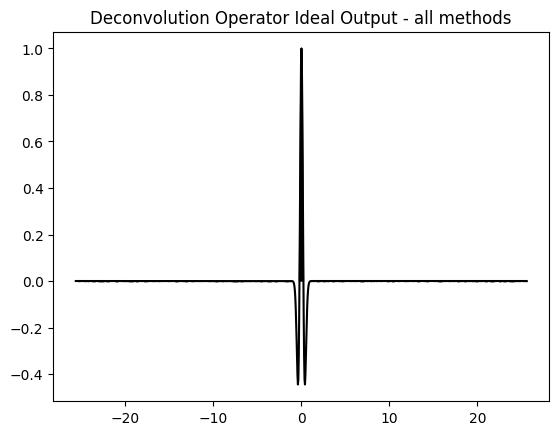

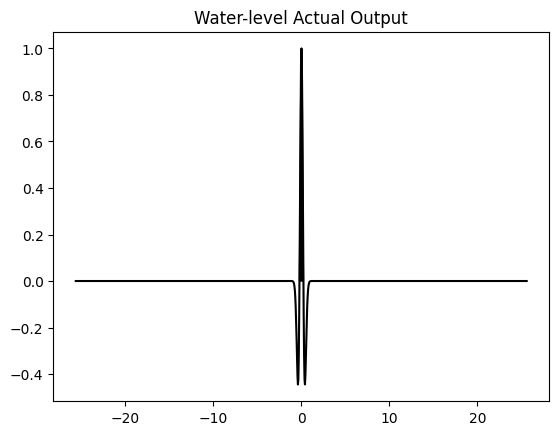

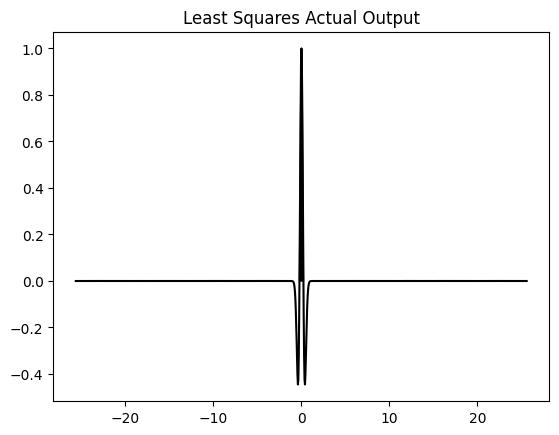

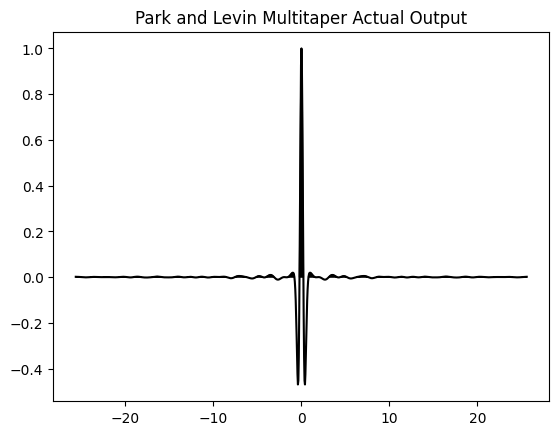

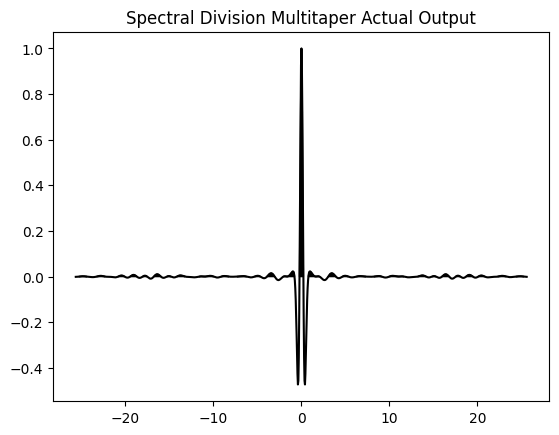

In [12]:
from mspasspy.ccore.seismic import TimeSeries
from mspasspy.algorithms.RFdeconProcessor import RFdeconProcessor
from mspasspy.util.seismic import print_metadata
wlprocessor=RFdeconProcessor(alg="WaterLevel")
wlprocessor.loaddata(dwn)
wlprocessor.loadwavelet(dwn)
decondata=wlprocessor.apply()
print(len(decondata))
ao1=wlprocessor.actual_output()
io1=wlprocessor.ideal_output()
# First we plot the idea output - all methods use this same shaping wavelet
# Hence we only plot it once.  If the parameter file is altered with 
# different shaping wavelets for different methods each needs a separate call 
# to the ideal_output method
plotter.title='Deconvolution Operator Ideal Output - all methods'
plotter.plot(TimeSeries(io1))
plt.show()

plotter.title='Water-level Actual Output'
plotter.plot(TimeSeries(ao1))
plt.show()

lsprocessor=RFdeconProcessor(alg="LeastSquares")
lsprocessor.loaddata(dwn)
lsprocessor.loadwavelet(dwn)
ao2=lsprocessor.actual_output()
plotter.title='Least Squares Actual Output'
plotter.plot(TimeSeries(ao2))
plt.show()

mtxcorproc = RFdeconProcessor(alg="MultiTaperXcor")
decon_data = RFdecon(dwn,mtxcorproc)
ao3=mtxcorproc.actual_output()
plotter.title='Park and Levin Multitaper Actual Output'
plotter.plot(TimeSeries(ao3))
plt.show()

mtspecproc = RFdeconProcessor(alg="MultiTaperSpecDiv")
decon_data = RFdecon(dwn,mtspecproc)
ao4=mtspecproc.actual_output()
plotter.title='Spectral Division Multitaper Actual Output'
plotter.plot(TimeSeries(ao4))
plt.show()


A lesson you should take from the above graphics is that one of the reasons the water level and least squares method perform badly on these data is that the actual output signal is almost identical to the ideal output signal.   In contast the multitaper actual outputs differ quite a bit from the ideal outputs. This is an example of a universal principle of linear inverse theory often described by what is called a "tradeoff-curve".   In the case of deconvlution it can stated this way:  the harder you try to make the deconvolution actual output match the ideal output the more you will raise the noise level of the output.  

You may want to explore how the actual output depends on the regularization parameter for each of these methods.  To do that edit the RFdeconProcessor.pf file as described above, run the cell that creates the processor of choice, and then rerun the cell above.  Alternatively, you can just tell jupyter to rerun this whole notebook after each edit.

## Color Noise Regularized Deconvolution (CNRRFDecon):
The examples above illustrates a fundamental problem with conventional methods of "receiver function" deconvolution even in the ideal situation when the wavelet is known to high accuracy.  That is, seismic noise is highly colored.  Both the water level and least squares method have roots  in reflection processing algorithms that are forms of so-called Wiener filters.  Wiener filter methods make assumption that the noise to be suppressed is white.  As noted above that is never true with passive array data recording of teleseismic body waves because the band of interest always crosses the strong peak from microseisms.   Furthermore, unlike reflection processing where the source amplitude and noise spectrum are approximately constant, earthquake signal amplitudes vary by many orders of magnitude and as any seismologists knows the source spectrum varies systematically with magnitude (amplitude).   Hence, the common practice of using a single recipe to process an entire data set leads to inconsistencies in the result that are commonly handled by aggressive editing of the output.   That problem leads to inefficient handling of data causing a large fraction of high signal-to-noise ratio events to be discarded.  Experimenting with this issue led me to recognize that the most fundamental problem is not what I, at least, once thought.   That is, as long term practitioner of classic linear inverse theory I had the misconception that it was all about getting the inverse operator right.   That remains true, but the solution is not with tunable parameters like the damping factor in the RFdecon methods we used above.   The fundamental issue is limiting the bandwidth of the output to a band were a resonable signal is present.  A key idea is that deconvolution operators shape the spectrum of the output to match the shaping wavelet.   If the shaping wavelet spectrum is inconsistent with the signal bandwidth the operator is guaranteed to amplify noise to create results like that observed above.   Note a spiking deconvolution is an extreme example since the spectrum of a delta function is all flat - the white noise assumption.     

To address this issue I developed a novel method in MsPASS with the cryptic name CNRRFDecon.  The name is intended to be mnemonic for Colored Noise Regularized RF (Receiver Function) Deconvolution.   We can understand it's behavior by applying it to the same data above that we showed creates issues for all the methods described above:

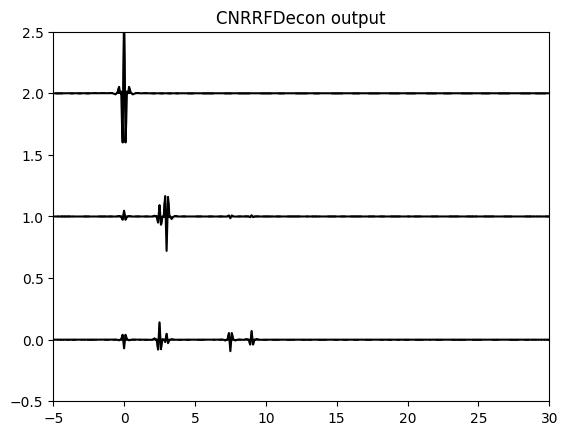

In [13]:
from mspasspy.ccore.utility import AntelopePf
from mspasspy.ccore.algorithms.deconvolution import CNRDeconEngine
from mspasspy.algorithms.CNRDecon import CNRRFDecon
from mspasspy.ccore.seismic import Seismogram

pf=AntelopePf('CNRDeconEngine.pf')
engine = CNRDeconEngine(pf)
d=Seismogram(dwn)
# set these manually for this demo
# later in the tutorial I show how to set these automatically in mspass
d['low_f_band_edge']=2.0
d['high_f_band_edge']=6.0
signal_window=TimeWindow(-5.0,30.0)
noise_window=TimeWindow(-40.0,-5.0)
decon_data = CNRRFDecon(d,
                        engine,
                        signal_window=signal_window,
                        noise_window=noise_window,
                       )
plotter.title="CNRRFDecon output"
plotter.plot(decon_data)
plt.show()

Notice that the output is both higher resolution and has a higher signal-to-noise ratio than any of the other methods we applied using RFdecon. 

To understand why it is helpful to examine the actual and ideal outputs of this operator.  For the actual output plot we plot the result above for the Multitaper method that differs most from the Ricker ideal ideal output.  

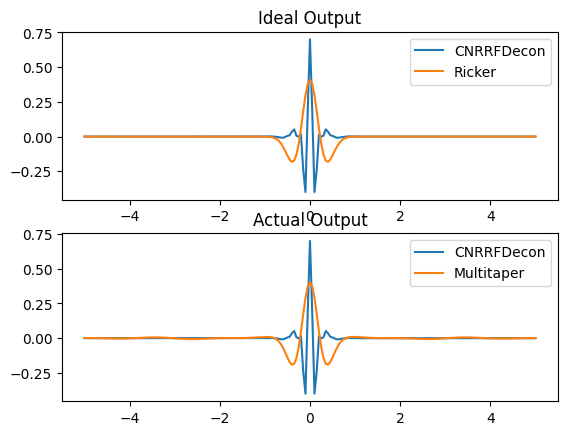

In [14]:
decon_data = CNRRFDecon(d,
                        engine,
                        signal_window=signal_window,
                        noise_window=noise_window,
                        return_wavelet=True,
                       )
ao = decon_data[1]
io = engine.ideal_output()
# window these down to allow seeing more detail
aow=WindowData(ao,-5,5)
iow=WindowData(io,-5,5)
io_ricker=WindowData(TimeSeries(io1),-5,5)
ao4w=WindowData(TimeSeries(ao4),-5,5)
fig,ax=plt.subplots(2)
ax[0].plot(iow.time_axis(),iow.data,label='CNRRFDecon')
ax[0].plot(io_ricker.time_axis(),io_ricker.data,label='Ricker')
ax[0].set_title('Ideal Output')
ax[0].legend()
ax[1].plot(aow.time_axis(),aow.data,label='CNRRFDecon')
ax[1].plot(ao4w.time_axis(),ao4w.data,label='Multitaper')
ax[1].set_title('Actual Output')
ax[1].legend()
plt.show()

These figures show why the output from CNRRFDecon has a higher resolution than the other methods that shaped the output to a Ricker wavelet.  The central  peak width of the CNRRFDecon actual operator is approximatley 1/3 that of Ricker wavelet approximation we extracted from the Multitaper algorithm.  Those with backgrounds in signal processing and inverse theory may find it surprising that a higher resolution operator could have a higher signal to noise ratio.   That, in fact, is very usual.   The reason is the first word in the CNR acronym: Colored.   The noise in this simulation is not at all white.  We can see that in the spectra plotted above, but is I will close this tutorial by examining that issue and how it impacts deconvolution more closely.

The next code box generates power spectrum estimates of the actual and ideal output signals for the CNRRFDecon operator.  It then shows the same spectra we computed earlier of the signal and noise but replotted on a log-log scale.  Run this next box and read the text below it to help understand the results.

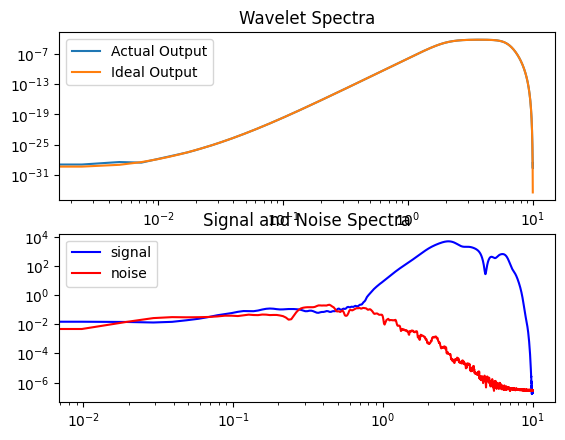

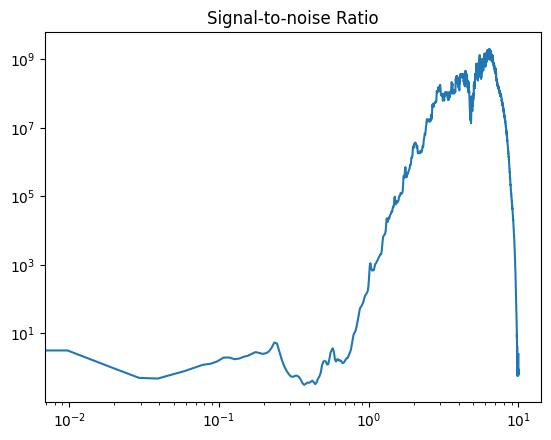

In [15]:
specengine=MTPowerSpectrumEngine(ao.npts,4.0,6,2048,ao.dt)
aospec=specengine.apply(ao)
iospec=specengine.apply(io)
fig,ax=plt.subplots(2)
ax[0].loglog(aospec.frequencies(),aospec.spectrum,label='Actual Output')
ax[0].loglog(iospec.frequencies(),iospec.spectrum,label='Ideal Output')
ax[0].set_title('Wavelet Spectra')
ax[0].legend()
ax[1].loglog(sigspec.frequencies(),sigspec.spectrum,'b-',label='signal')
ax[1].loglog(nspec.frequencies(),nspec.spectrum,'r-',label='noise')
ax[1].set_title('Signal and Noise Spectra')
ax[1].legend()
plt.show()
snr = np.zeros(sigspec.nf())
for i in range(sigspec.nf()):
    f = sigspec.frequency(i)
    n = nspec.power(f)
    # unresolved but in power method at Nyquist - returns 0
    # this is a crude workaround.  
    if n==0.0:
        n=1e-7
    snr[i] = sigspec.spectrum[i]/n
plt.loglog(sigspec.frequencies(),snr)
plt.title("Signal-to-noise Ratio")
plt.show()

This shows the property of the CNRRFDecon operator I discussed when I introduced it above.  That is, the bandwidth of the response (actual output) has been shaped to match the bandwidth of the data.   When we defined the operator that bandwith as set by the following two lines of code extracted from the box above where we created the data used to create the spectra plotted above:
```
  d['low_f_band_edge']=2.0
  d['high_f_band_edge']=6.0
```
The CNRDeconEngine class we generated (the fancy IT word is "instantiated") to use with CNRRFDecon requires those attributes to define the bandwidth it should use.  The output is the "shaped" to try to match the ideal output plotted above.  A technical detail is that the ideal output wavelet is the impulse response of a "zero-phase, 3-pole, Butterworth bandpass filter". The corner frequencies for the bandpass filter are set as 2.0 to 6.0 Hz via the Metadata attributes with the verbose names immediately above.  Currently a zero-phase Butterworth shaping filter is the only option for a CNRDeconEngine instance, but I expect to add addition options in the future.   

The key point for this simulation example is that the reason CNRRFDecon has a higher signal-to-noise ratio is that the bandwidth of that zero-phase Butterworth filter matches the range where the signal-to-noise ratio is greater than 1.  In contrast the Ricker wavelet bandwidth is completely wrong as demonstrated in the graphics produced by the following code box:

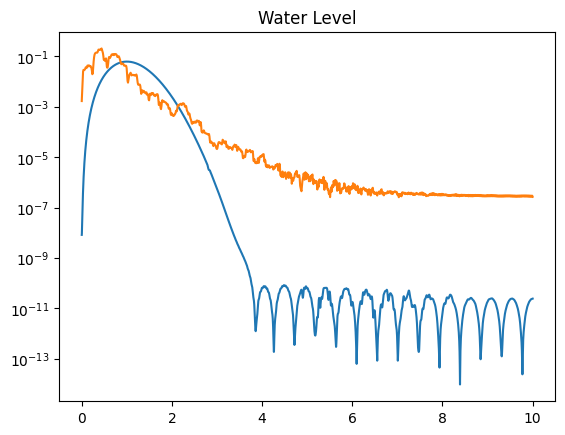

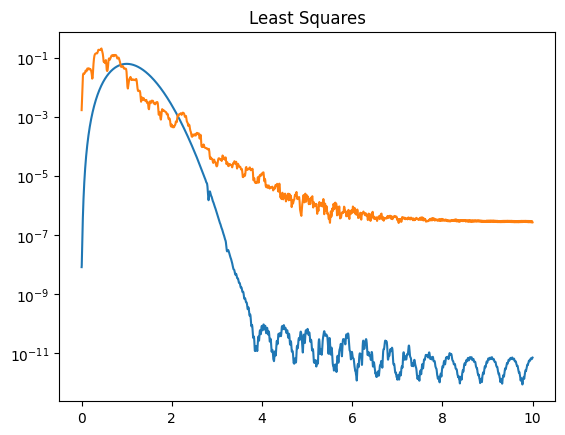

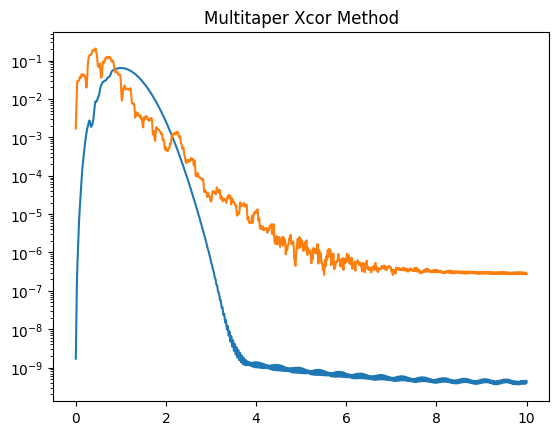

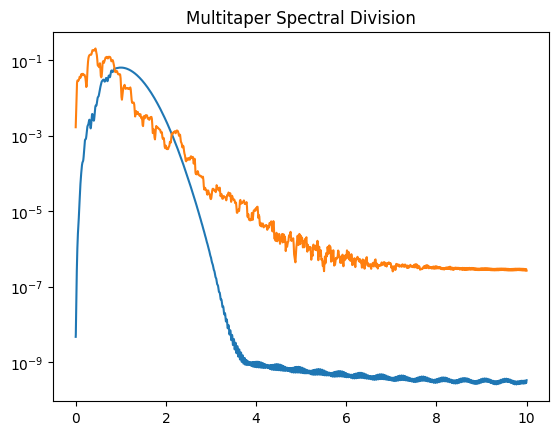

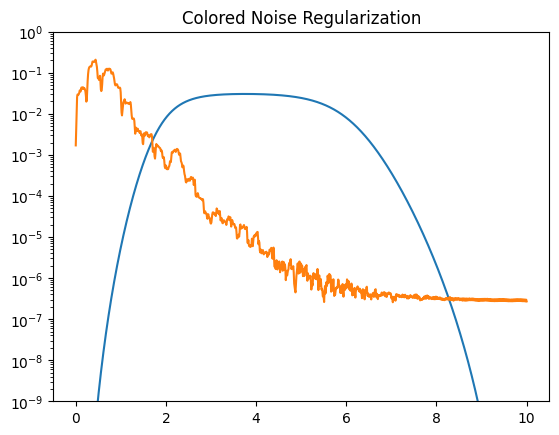

In [16]:
import numpy as np
def normalize_spectrum(s):
    """
    Normalizes spectrum object s to have L2 norm 1.  
    Needed for plot scaling for this tutorial.
    """
    nrms = np.linalg.norm(s.spectrum)
    s.spectrum /= nrms
    return s
    
# Call to TimeSeries constructor an oddity of the currert implementation
ao1spec=specengine.apply(TimeSeries(ao1))
ao2spec=specengine.apply(TimeSeries(ao2))
ao3spec=specengine.apply(TimeSeries(ao3))
ao4spec=specengine.apply(TimeSeries(ao4))
ao1spec = normalize_spectrum(ao1spec)
ao2spec = normalize_spectrum(ao2spec)
ao3spec = normalize_spectrum(ao3spec)
ao4spec = normalize_spectrum(ao4spec)
aospec = normalize_spectrum(aospec)
nspec = normalize_spectrum(nspec)
plt.semilogy(ao1spec.frequencies(),ao1spec.spectrum,'-',
            nspec.frequencies(),nspec.spectrum,'-',
            )
plt.title('Water Level')
plt.show()

plt.semilogy(ao2spec.frequencies(),ao2spec.spectrum,'-',
             nspec.frequencies(),nspec.spectrum,'-',
            )
plt.title('Least Squares')
plt.show()
plt.semilogy(ao3spec.frequencies(),ao3spec.spectrum,'-',
             nspec.frequencies(),nspec.spectrum,'-',
            )
plt.title("Multitaper Xcor Method")
plt.show()
plt.semilogy(ao4spec.frequencies(),ao4spec.spectrum,'-',
             nspec.frequencies(),nspec.spectrum,'-',
            )
plt.title("Multitaper Spectral Division")
plt.show()
plt.semilogy(aospec.frequencies(),aospec.spectrum,'-',
             nspec.frequencies(),nspec.spectrum,'-',
            )
# needed to get this plot similar scale to above
plt.ylim(1e-9,1)
plt.title("Colored Noise Regularization")
plt.show()

These graphics demonstrate that my simulation was contrived to emphasize the key point of CNRRFDecon:   if you use a single bandwidth for all data, which is the case for all implementations of the water level and least squares methods I know of, situations like above are the norm.   That is the bandwidth of the desired (ideal) output can easily be inconsistent with data bandwidth amplifying noise like the examples above.  tThe CNR algorithm attempts to get around the colored noise issue by varying the bandwidth of each signal it encounters.  The dark side is the impulse response of the output will not be consistent from station to station.  Although unproven, my working hypothesis is that approach is superior for direct imaging methods like CCP stacking and the 3D plane wave migration algorithm I developed a number of years ago (Pavlis, 2011:  see also [orignal code base repository](https://github.com/pavlis/pwmig) or new [parallel version with python wrappers](https://github.com/pavlis/parallel_pwmig)).  It will should probably not be used for crustal inversion applications without modification as there knowledge of the detailed shape of the ideal output is probably essential.   

### Setting the bandwidth for CNRRFDecon
The final topic for this tutorial is critical for using CNRRFDecon on real data.  In the example above I set the bandwidth of the output manually with the lines:
```
  d['low_f_band_edge']=2.0
  d['high_f_band_edge']=6.0
```
The MsPASS tool for setting those attributes automatically is called "broadband_snr_QC".   See the [docstring](https://www.mspass.org/python_api/mspasspy.algorithms.html#mspasspy.algorithms.snr.broadband_snr_QC) for what the function does and how it works. For this tutorial I will just run it on the simulation data to show how to run it to set the bandwidth for CNRRFDecon. 

In [17]:
from mspasspy.algorithms.snr import broadband_snr_QC
from mspasspy.util.seismic import print_metadata
# repeated from above but set here to be clear for tutorial
sigwindow=TimeWindow(-5.0,30.0)
nwindow=TimeWindow(-40.0,-5.0)
dcpy = Seismogram(dwn)
# normally this would be set as a P wave arrival time estimate. 
# this is a trick to allow this to work with this simulation data
# it would normally be defined with a UTC P wave pick or model time
dcpy['Ptime']=0.0
d = broadband_snr_QC(dcpy,
                     signal_window=sigwindow,
                     noise_window=nwindow,
                     band_cutoff_snr=2.0,
                     use_measured_arrival_time=True,
                     measured_arrival_time_key='Ptime',
                    )
qcdata = d['Parrival']
print_metadata(qcdata)

{
  "low_f_band_edge": 0.7560627674750356,
  "high_f_band_edge": 8.002853067047075,
  "low_f_band_edge_snr": 1.7315635138412877,
  "high_f_band_edge_snr": 5313.611655795303,
  "spectrum_frequency_range": 10.0,
  "bandwidth": 20.493739833107448,
  "bandwidth_fraction": 0.724679029957204,
  "filter_type": "bandpass",
  "filter_number_poles": 3,
  "median_snr": 10672.163744067388,
  "q1_4_snr": 4055.5603980616197,
  "q3_4_snr": 19259.55200584306,
  "maximum_snr": 44606.27494870963,
  "stats_are_valid": true,
  "mean_snr": 13104.759124260818,
  "minimum_snr": 1.7315635138412877,
  "snr_filtered_envelope_peak": 6840.697097028687,
  "snr_filtered_rms": 557.1640794232999,
  "snr_filtered_peak": 3593.580048477417,
  "snr_filtered_mad": 1.0596553273834057,
  "snr_filtered_perc": 38.88636038389683,
  "snr_perc": 95.0,
  "phase": "P",
  "snr_arrival_time": 0.0,
  "snr_signal_window_start": -5.0,
  "snr_signal_window_end": 30.0,
  "snr_noise_window_start": -40.0,
  "snr_noise_window_end": -5.0
}


Notice that broadband_snr_QC by default writes its results to a python dictionary accessed with the (default) key value of "Parrival".   Notice also it computes a long list of metrics.   More details on what these attributes are can be found on [this page](https://www.mspass.org/user_manual/signal_to_noise.html) of the mspass user's manual.  A critical point for RF processing is a robust workflow should not attempt to deconvolve any data for which one or more of these metrics are too small. (e.g. `qcdata["maximum_snr"]<5.0`).  

CNRRFDecon was designed to be run on data previously processed with broadband_snr_QC.  Here is the output run on dcpy where the bandwidth is set automatically with the broadband_snr_QC algorithm:

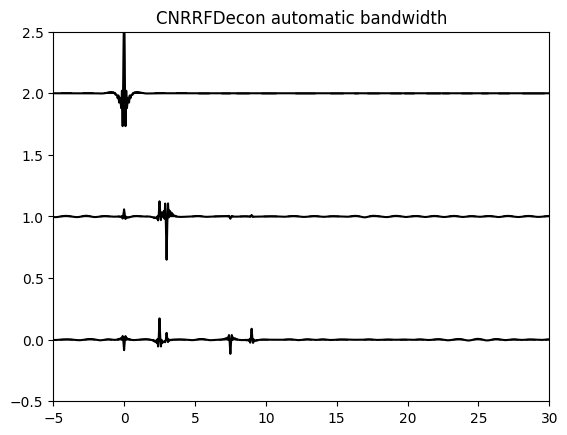

In [18]:
# repeat these for clarity even if they were actually 
# defined above
pf=AntelopePf('CNRDeconEngine.pf')
engine = CNRDeconEngine(pf)
signal_window=TimeWindow(-5.0,30.0)
noise_window=TimeWindow(-40.0,-5.0)
decon_data = CNRRFDecon(dcpy,
                        engine,
                        signal_window=signal_window,
                        noise_window=noise_window,
                        bandwidth_subdocument_key="Parrival",
                       )
plotter.title="CNRRFDecon automatic bandwidth"
plotter.plot(decon_data)
plt.show()

The results are higher resolution, but also have more low-frequency noise.   The reason is that the bandwidth estimate returned by broadband_snr_QC is 0.6 to 8 Hz while my manually set bandwidth as 2 to 6 Hz.  The Butterworth bandpass filter sets the bandpass corner frequencies from the attributes "low_f_band_edge" and "high_f_band_edge".  The numbers broadband_snr_QC returns are near the edge of the frequency band.  I am still learning practical issues with ths algorithm, but I suspect an appropriate recipe to add to any workflow is a function like the following:

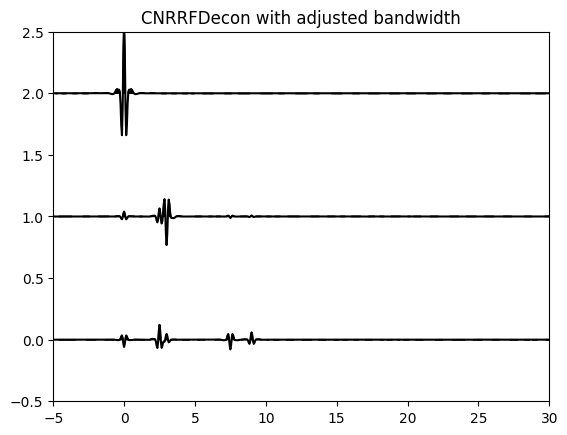

In [19]:
def set_CNR_bandwidth(d,
                      bandwidth_subdocument_key="Parrival",
                     f_low_factor=2.0,
                     f_high_factor=0.5):
    """
    Untested prototype  function to adjust bandwidth estimates from 
    broadband_snr_QC to adjust for filter rolloff.   
    """
    qcdoc = d[bandwidth_subdocument_key]
    flow = qcdoc['low_f_band_edge']
    flow *= f_low_factor
    d['low_f_band_edge'] = flow
    fhigh = qcdoc['high_f_band_edge']
    fhigh *= f_high_factor
    d['high_f_band_edge'] = fhigh
    return d

# application to test data - note change CNRRFDecon arguments
# defaults assume the special keys used in set_CNR_bandwidth
dcpy = set_CNR_bandwidth(dcpy)
decon_data = CNRRFDecon(dcpy,
                        engine,
                        signal_window=signal_window,
                        noise_window=noise_window,
                       )
plotter.title="CNRRFDecon with adjusted bandwidth"
plotter.plot(decon_data)
plt.show()
    

## Array Deconvolution
There is a prototype implementation of an array deconvolution version of the CNR algorithm.   At the time of the last update of this tutorial (January 2025) that algorithm was in the repository but not as thoroughly tested as I would like for routine use.   Use it at your own risk and watch for updates   The algorithm is implemented as the function "CNRArrayDecon" defined in the same python module as CNRRFDecon.  Look for a planned future tutorial using CNRArrayDecon in combination with an teleseisic array stacking module.  The idea of that method is to use larger aperture array stacks to estimate a higher snr wavelet that is used to deconvolve common source gathers.   